In [20]:
import os
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from skimage.filters import sobel
from kornia.filters import Canny, canny, sobel   # use directly on tensors
from skimage import color, data
from skimage.transform import resize
from sklearn.base import BaseEstimator
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from skorch import NeuralNet, NeuralNetRegressor
from torch.utils.data import DataLoader, TensorDataset, random_split, Subset
from tqdm.auto import tqdm

from src.dataset_benchm import OVAS, all_datasets
from src.train import eval_loop

In [37]:
dataset = OVAS('train', expand=False)
# dataset = Subset(dataset, np.arange(20))

In [38]:
CSV_FILE = 'grid_metrics_canny_2.csv'

In [39]:
class ThresholdModel(nn.Module):
    def __init__(self, t=.5, low_threshold=.1, high_threshold=.2, kernel_size=(5,5), sigma=(1,1), hysteresis=True, eps=1e-6):
        super(ThresholdModel, self).__init__()
        self.t = torch.tensor([t])
        self.low_threshold = low_threshold
        self.high_threshold = low_threshold
        self.kernel_size = kernel_size
        self.sigma = sigma
        self.hysteresis = hysteresis
        self.eps = eps

    def forward(self, x):
        magnitude, edges = canny(x[:, 1:2, :, :], self.low_threshold, self.high_threshold, self.kernel_size, self.sigma, self.hysteresis, self.eps)
        edges = edges > self.t.item()
        return  edges.float()

In [40]:
[i.size() for i in dataset[0]]

[torch.Size([4, 256, 256]), torch.Size([1, 256, 256])]

In [66]:
ind = np.random.choice(range(len(dataset)))
ind = np.int64(962)

/tmp/54257791/ipykernel_4190102/3742320867.py:5: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  axes[0].imshow(np.array(image))


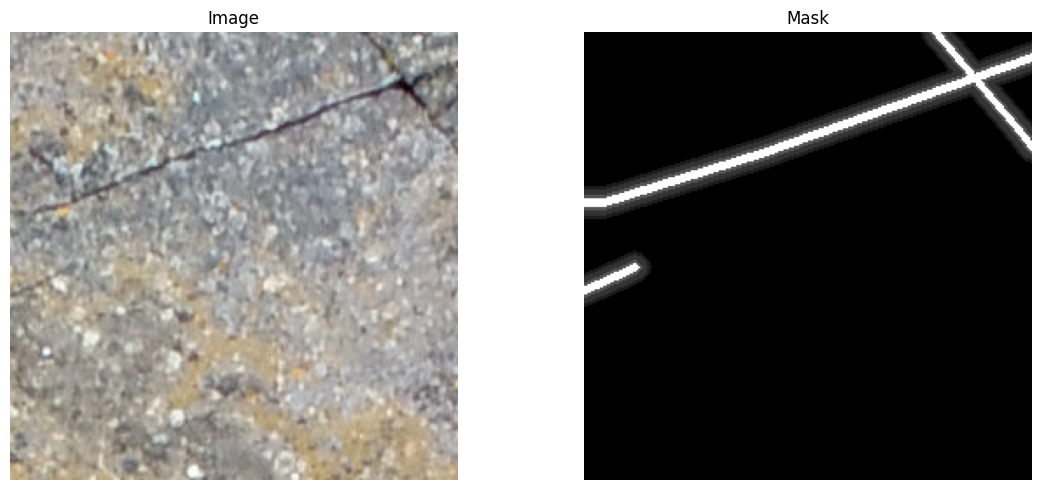

In [67]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
image = dataset[ind][0].permute(1, 2, 0)[:, :, :3] / 255.
mask = dataset[ind][1].permute(1, 2, 0)

axes[0].imshow(np.array(image))
axes[0].set_title('Image')
axes[0].axis('off')
axes[0].grid([])

axes[1].imshow(mask, cmap='gray')
axes[1].set_title('Mask')
axes[1].axis('off')
axes[1].grid([])

fig.tight_layout()

In [68]:
model_ = ThresholdModel(t=0.5)

In [69]:
pred = model_(dataset[ind][0].unsqueeze(0))

In [70]:
dataset[ind][0].shape

torch.Size([4, 256, 256])

In [71]:
# https://kornia.readthedocs.io/en/latest/filters.html#kornia.filters.Canny
magnitude, edges = Canny(low_threshold=.1, high_threshold=.2, hysteresis=True, kernel_size=(9,9), sigma=(11,11)
                        )(dataset[ind][0][:3, :, :].unsqueeze(0)) 
magnitude.shape
edges.shape

torch.Size([1, 1, 256, 256])

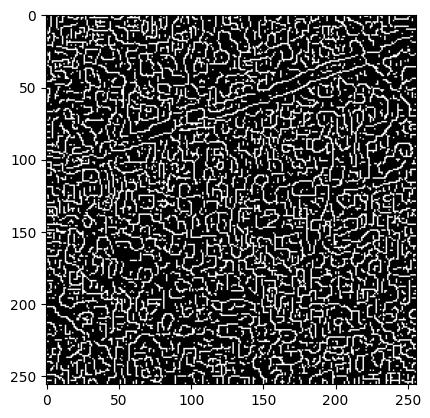

In [72]:
plt.imshow(edges.squeeze(0).permute(1, 2, 0), cmap='gray')

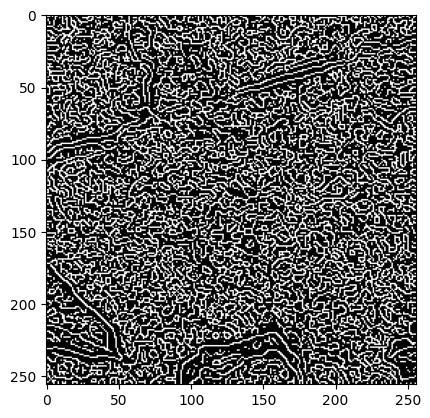

In [15]:
plt.imshow(pred.squeeze(0,1), cmap='gray')

In [16]:
CALCULATED_METRICS = ('mse', 'psnr', 'ssim', 'ae', 'acc', 'f1', 'prec', 'rec', 'roc_auc', 'iou_nbg', 'loss')

In [17]:
class Estimator(BaseEstimator):
    def __init__(self, threshold=.5, low_threshold=.1, high_threshold=.2, kernel_size=(5,5), sigma=(1,1), hysteresis=True, eps=1e-6, lr=1e-3, epochs=1, batch_size=32):
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.threshold = threshold
        self.low_threshold = low_threshold
        self.high_threshold = low_threshold
        self.kernel_size = kernel_size
        self.sigma = sigma
        self.hysteresis = hysteresis
        self.eps = eps

    def fit(self, X, y=None):
        dataset = X
        valloader = DataLoader(dataset, batch_size=self.batch_size)
        self.model = ThresholdModel(self.threshold, self.low_threshold, self.high_threshold, self.kernel_size, self.sigma, self.hysteresis, self.eps).cuda()
        criterion = nn.HuberLoss()

        # Evaluate on val set for scoring
        self.model.eval()
        scheduler = None
        self.metrics = eval_loop(self.model, scheduler, criterion, valloader,
                            self.threshold, 'cuda')
        self.val_accuracy = self.metrics['f1'] + self.metrics['roc_auc'] + self.metrics['iou_nbg']
        print(f'Val accuracy: {self.val_accuracy}')        

        return self

    def score(self, X, y=None):
        row = {
            'threshold':self.threshold,
            'low_threshold': self.low_threshold,
            'high_threshold': self.high_threshold,
            'kernel_size': self.kernel_size,
            'sigma': self.sigma,
            'hysteresis': self.hysteresis,
            'eps': self.eps,
            **self.metrics
        }

        df = pd.DataFrame([row])
        if not os.path.exists(CSV_FILE):
            df.to_csv(CSV_FILE, index=False)
        else:
            df.to_csv(CSV_FILE, mode='a', header=False, index=False)

        return self.val_accuracy

In [18]:
[1.e-07, 1.e-06, 1.e-05, 1.e-04]

[1e-07, 1e-06, 1e-05, 0.0001]

In [ ]:
param_grid = {
    'threshold': np.arange(0, 1, 0.2),
    'low_threshold': np.arange(.1, .5, 0.1),
    'high_threshold': np.arange(.2, 1, 0.2),
    'kernel_size': [(5, 5), (7, 7), (9, 9)],
    'sigma': [(1, 1), (3, 3), (5, 5)],
    'hysteresis': [True, False],
    'eps': [1.e-07, 1.e-06],  #, 1.e-05, 1.e-04],
}

grid = GridSearchCV(Estimator(), param_grid, scoring=None, cv=2)
grid.fit(dataset)

print(grid.best_params_)
print(grid.best_score_)

Iterating over evaluation data: 100%|██████████████████████████████| 71/71 [01:44<00:00,  1.48s/it]


Val accuracy: 0.7138794082365845


Iterating over evaluation data: 100%|██████████████████████████████| 71/71 [01:40<00:00,  1.41s/it]


Val accuracy: 0.7121877642571922


Iterating over evaluation data: 100%|██████████████████████████████| 71/71 [01:39<00:00,  1.40s/it]


Val accuracy: 0.7068039199113358


Iterating over evaluation data: 100%|██████████████████████████████| 71/71 [01:39<00:00,  1.40s/it]


Val accuracy: 0.7022015048461704


Iterating over evaluation data: 100%|██████████████████████████████| 71/71 [01:38<00:00,  1.39s/it]


Val accuracy: 0.7046521536863937


Iterating over evaluation data: 100%|██████████████████████████████| 71/71 [01:39<00:00,  1.41s/it]


Val accuracy: 0.7138794082365845


Iterating over evaluation data: 100%|██████████████████████████████| 71/71 [01:38<00:00,  1.39s/it]


Val accuracy: 0.7121877642571922


Iterating over evaluation data: 100%|██████████████████████████████| 71/71 [01:38<00:00,  1.38s/it]


Val accuracy: 0.7068039199113358


Iterating over evaluation data: 100%|██████████████████████████████| 71/71 [01:38<00:00,  1.39s/it]


Val accuracy: 0.7022015048461704


Iterating over evaluation data: 100%|██████████████████████████████| 71/71 [01:38<00:00,  1.39s/it]


Val accuracy: 0.7046521536863937


Iterating over evaluation data: 100%|██████████████████████████████| 71/71 [01:39<00:00,  1.40s/it]


Val accuracy: 0.7138794082365845


Iterating over evaluation data: 100%|██████████████████████████████| 71/71 [01:38<00:00,  1.38s/it]


Val accuracy: 0.7121877642571922


Iterating over evaluation data: 100%|██████████████████████████████| 71/71 [01:37<00:00,  1.38s/it]


Val accuracy: 0.7068039199113358


Iterating over evaluation data: 100%|██████████████████████████████| 71/71 [01:39<00:00,  1.41s/it]


Val accuracy: 0.7022015048461704


Iterating over evaluation data: 100%|██████████████████████████████| 71/71 [01:38<00:00,  1.38s/it]


Val accuracy: 0.7046521536863937


Iterating over evaluation data: 100%|██████████████████████████████| 71/71 [01:37<00:00,  1.38s/it]


Val accuracy: 0.7138794082365845


Iterating over evaluation data: 100%|██████████████████████████████| 71/71 [01:38<00:00,  1.38s/it]


Val accuracy: 0.7121877642571922


Iterating over evaluation data: 100%|██████████████████████████████| 71/71 [01:37<00:00,  1.37s/it]


Val accuracy: 0.7068039199113358


Iterating over evaluation data: 100%|██████████████████████████████| 71/71 [01:38<00:00,  1.38s/it]


Val accuracy: 0.7022015048461704


Iterating over evaluation data: 100%|██████████████████████████████| 71/71 [01:38<00:00,  1.38s/it]


Val accuracy: 0.7046521536863937


Iterating over evaluation data: 100%|██████████████████████████████| 71/71 [01:38<00:00,  1.39s/it]


Val accuracy: 0.7138794082365845


Iterating over evaluation data: 100%|██████████████████████████████| 71/71 [01:38<00:00,  1.38s/it]


Val accuracy: 0.7121877642571922


Iterating over evaluation data: 100%|██████████████████████████████| 71/71 [01:38<00:00,  1.38s/it]


Val accuracy: 0.7068039199113358


Iterating over evaluation data: 100%|██████████████████████████████| 71/71 [01:38<00:00,  1.38s/it]


Val accuracy: 0.7022015048461704


Iterating over evaluation data: 100%|██████████████████████████████| 71/71 [01:38<00:00,  1.38s/it]


Val accuracy: 0.7046521536863937


Iterating over evaluation data: 100%|██████████████████████████████| 71/71 [01:38<00:00,  1.38s/it]


Val accuracy: 0.704036598405932


Iterating over evaluation data: 100%|██████████████████████████████| 71/71 [01:37<00:00,  1.38s/it]


Val accuracy: 0.7022129090031184


Iterating over evaluation data: 100%|██████████████████████████████| 71/71 [01:37<00:00,  1.38s/it]


Val accuracy: 0.6971661561815894


Iterating over evaluation data: 100%|██████████████████████████████| 71/71 [01:37<00:00,  1.38s/it]


Val accuracy: 0.6929863735034106


Iterating over evaluation data: 100%|██████████████████████████████| 71/71 [01:38<00:00,  1.38s/it]


Val accuracy: 0.6954730965408993


Iterating over evaluation data:  54%|████████████████              | 38/71 [00:55<00:48,  1.46s/it]


KeyboardInterrupt: 

In [ ]:
import pandas as pd

df = pd.read_csv(CSV_FILE)

keep_indices = []
i = 0
while i < len(df):
    keep_indices.append(i)
    i += 5  # skip 4, move to next keep

df_filtered = df.iloc[keep_indices].reset_index(drop=True)
df_filtered.to_csv(CSV_FILE, index=False)

param_grid = {
    'threshold': np.arange(0.8, 1., 0.01),
}

grid = GridSearchCV(Estimator(), param_grid, scoring=None, cv=2)
grid.fit(dataset)

print(grid.best_params_)
print(grid.best_score_)

In [12]:
grid.cv_results_['mean_test_score']

array([0.85389939, 0.85389939, 0.85389939, 0.85389939, 0.85389939,
       0.85389939, 0.85389939, 0.85389939, 0.85389939, 0.85447069])

In [13]:
grid.cv_results_['params']

[{'threshold': np.float64(0.8)},
 {'threshold': np.float64(0.81)},
 {'threshold': np.float64(0.8200000000000001)},
 {'threshold': np.float64(0.8300000000000001)},
 {'threshold': np.float64(0.8400000000000001)},
 {'threshold': np.float64(0.8500000000000001)},
 {'threshold': np.float64(0.8600000000000001)},
 {'threshold': np.float64(0.8700000000000001)},
 {'threshold': np.float64(0.8800000000000001)},
 {'threshold': np.float64(0.8900000000000001)}]